# Performance Comparison

## Corridor Map

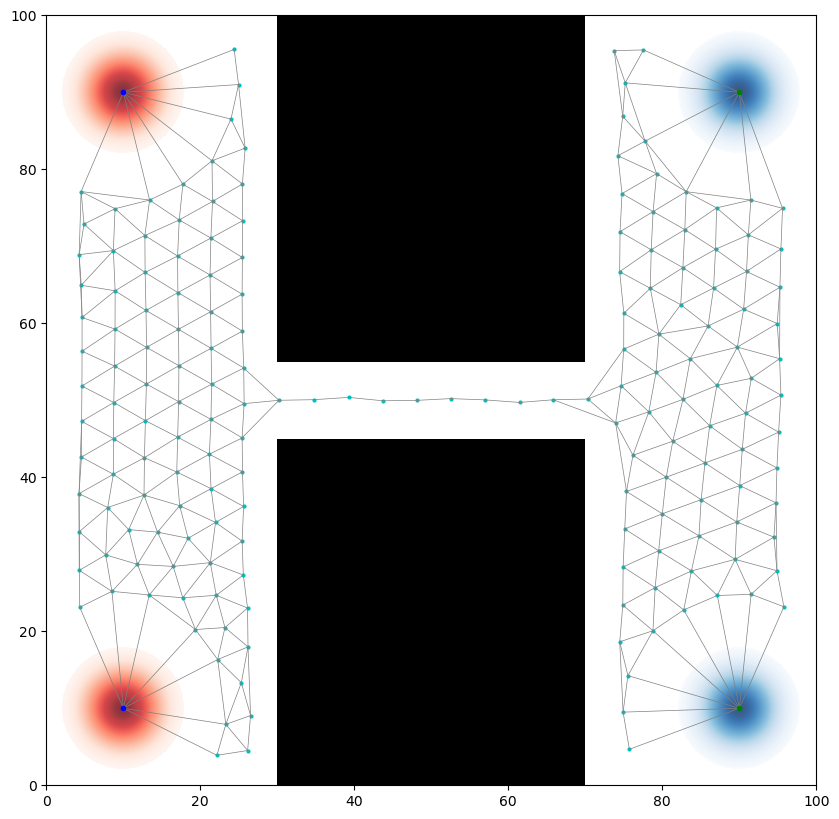

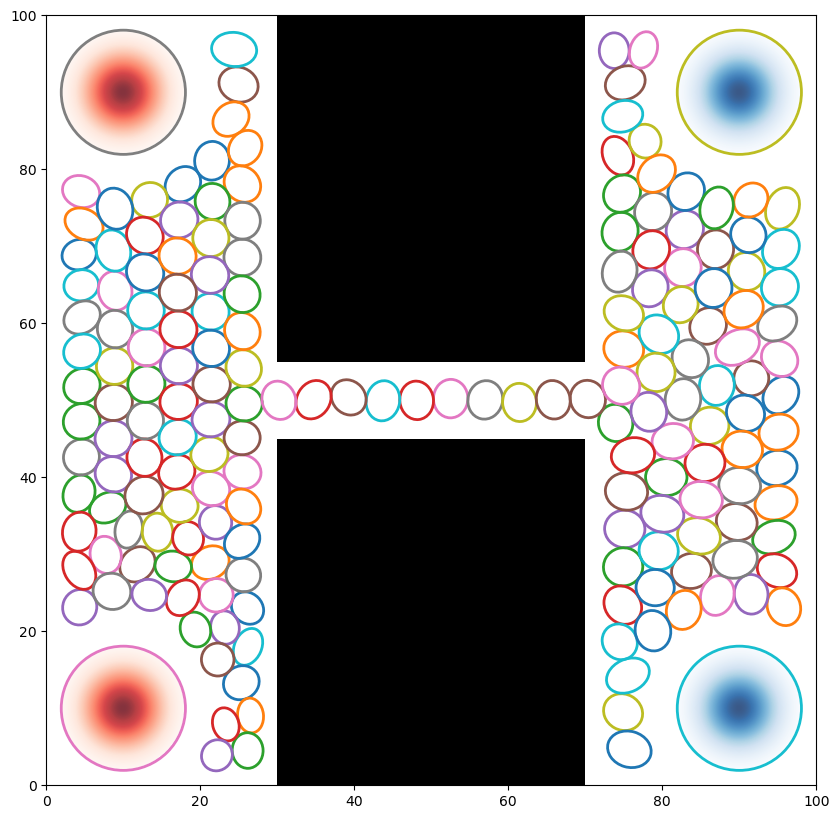

In [1]:
import pickle
import numpy as np

from swarm_prm.solvers.utils.gaussian_prm import GaussianPRM
from swarm_prm.solvers.utils.gaussian_utils import GaussianGraphNode
from swarm_prm.envs.roadmap import Roadmap, Obstacle 
from swarm_prm.envs.instance import Instance

roadmap = Roadmap(100, 100)
safety_radius = 2 
pos = np.array([50, 50])
obstacles  = [
    Obstacle(None, "POLYGON", [(30, 0), (30, 45), (70, 45), (70, 0)]),
    Obstacle(None, "POLYGON", [(30, 100), (30, 55), (70, 55), (70, 100)])
]
num_samples = 200 
for obs in obstacles:
    roadmap.add_obstacle(obs)
# fig, ax = roadmap.visualize()
start_mean = np.random.rand(2) * 100
goal_mean = np.random.rand(2) * 100

# Agent config
num_agent = 400
agent_radius = 0.5
sampling_method = "GAUSSIAN_SAMPLING"
hex_radius = 3
TEST_CVAR = False


# Curated test instance
starts = np.array([[10, 10], [10, 90]])
goals = np.array([[90, 90], [90, 10]])

starts_weight = np.array([.5, .5])
goals_weight = np.array([.5, .5])
# starts_weight = np.array([1, 0])
# goals_weight = np.array([0, 1])

g_starts = [GaussianGraphNode(start, None, "UNIFORM", radius=10) for start in starts]
g_goals = [GaussianGraphNode(goal, None, "UNIFORM", radius=10) for goal in goals]

instance = Instance(roadmap, g_starts, g_goals, starts_weight, goals_weight)

gaussian_prm = GaussianPRM(instance, num_samples, safety_radius=safety_radius,
                           hex_radius=hex_radius)
gaussian_prm.sample_free_space(sampling_strategy="CVT")
gaussian_prm.load_instance()
gaussian_prm.build_roadmap(roadmap_method="TRIANGULATION", radius=10, collision_check_method="CVAR")
fig, ax = gaussian_prm.visualize_roadmap("test_map")
gaussian_prm.visualize_g_nodes()

from matplotlib.patches import Circle

for start in g_starts:
    mean = start.get_mean()
    radius = start.get_radius()
    ax.add_patch(Circle(mean, radius))

with open("gaussian_prm.pkl", "wb") as f:
    pickle.dump(gaussian_prm, f)


### 

In [2]:
import pickle
from swarm_prm.solvers.macro.teg import TEGGraph 

with open("gaussian_prm.pkl", "rb") as f:
    gaussian_prm = pickle.load(f)

teg_graph= TEGGraph(gaussian_prm, agent_radius, num_agents=num_agent, max_timestep=500)
max_flow, flow_dict, timestep, teg, paths, residual_graph = teg_graph.get_earliest_timestep()

# from pprint import pprint
# pprint(flow_dict)

Time step:  23 Max Flow:  120
Time step:  24 Max Flow:  240
Time step:  25 Max Flow:  360
Time step:  26 Max Flow:  400


{23: {179: [(179, 80)], 63: [(34, 40)], 34: [(40, 120)], 17: [(14, 80)], 18: [(17, 40)], 40: [(178, 40)]}, 0: {177: [(140, 132), (121, 68)], 176: [(77, 134), (44, 66)]}, 1: {140: [(177, 92), (120, 40)], 121: [(140, 68)], 77: [(84, 14), (45, 120)], 44: [(77, 66)]}, 2: {177: [(140, 92)], 140: [(177, 40), (120, 28)], 77: [(45, 66)], 84: [(52, 14)], 120: [(152, 40)], 45: [(47, 99), (48, 21)]}, 3: {177: [(140, 40)], 140: [(151, 92)], 52: [(51, 14)], 120: [(152, 28)], 45: [(47, 66)], 47: [(105, 99)], 48: [(105, 21)], 152: [(157, 40)]}, 4: {140: [(151, 40)], 51: [(54, 14)], 47: [(105, 66)], 151: [(157, 92)], 157: [(167, 40)], 152: [(157, 28)], 105: [(103, 120)]}, 5: {151: [(157, 40)], 157: [(167, 120)], 167: [(172, 40)], 105: [(103, 66)], 54: [(106, 14)], 103: [(128, 120)]}, 6: {157: [(167, 40)], 172: [(171, 40)], 167: [(172, 120)], 128: [(145, 120)], 106: [(126, 14)], 103: [(128, 66)]}, 7: {172: [(171, 120)], 171: [(168, 40)], 167: [(172, 40)], 128: [(145, 66)], 145: [(166, 120)], 126: [(145

TypeError: float() argument must be a string or a real number, not 'GaussianGraphNode'

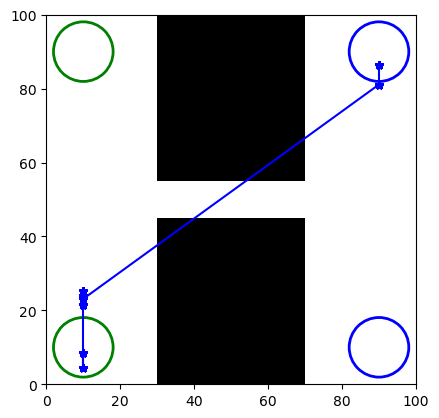

In [ ]:
import pickle
from matplotlib import pyplot as plt
from swarm_prm.solvers.micro import GaussianTrajectorySolver

simple_paths = gaussian_prm.get_solution(flow_dict, timestep, num_agent)
macro_solution = gaussian_prm.get_macro_solution(flow_dict)
print(macro_solution)

timestep = max(macro_solution.keys())


gt_solver = GaussianTrajectorySolver(gaussian_prm, macro_solution, timestep, num_agent, safety_gap=0)
gt_paths = gt_solver.solve()
fig, ax = instance.visualize()

for path in simple_paths:
    x_coords = [loc[0] for loc in path]
    y_coords = [loc[1] for loc in path]
    ax.plot(x_coords, y_coords, '-*', label='Path', color='blue')
# 
cmap = plt.get_cmap("tab10")
# 
for i, path in enumerate(gt_paths):
    x_coords = [loc[0] for loc in path]
    y_coords = [loc[1] for loc in path]
    ax.plot(x_coords, y_coords, '--', label='Path', color=cmap(i%10))

In [ ]:
print(macro_solution)

In [ ]:
import pickle
from swarm_prm.solvers.macro.drrt import DRRT


with open("gaussian_prm.pkl", "rb") as f:
    gaussian_prm = pickle.load(f)

num_agent = 2
agent_radius = 1

drrt_solver = DRRT(gaussian_prm, agent_radius, num_agent)
path, cost= drrt_solver.get_solution()


In [ ]:
from matplotlib import pyplot as plt
fig, ax = gaussian_prm.visualize_roadmap()

for agent in range(num_agent):
    locations = [gaussian_prm.samples[location_idx[agent]] for location_idx in path]
    x = [loc[0] for loc in locations]
    y = [loc[1] for loc in locations]
    ax.plot(x, y, "-")
print(path)
plt.show()

## Export Results

## Obstacle Map

In [ ]:
import pickle

from swarm_prm.solvers.utils.gaussian_prm import *
from swarm_prm.envs.roadmap import Roadmap, Obstacle 
from swarm_prm.envs.instance import Instance

# Replicate of map from SwarmCVT

roadmap = Roadmap(200, 160)
safety_radius = 2 
pos = np.array([50, 50])
obstacles  = [
    Obstacle(None, "POLYGON", [(50, 0), (60, 75), (75, 75), (90, 40), (90, 0)]),
    Obstacle(None, "POLYGON", [(50, 130), (75, 127), (80, 100), (55, 103)]),
    Obstacle(None, "POLYGON", [(100, 150), (140, 150), (140, 125), (110, 125)]),
    Obstacle(None, "POLYGON", [(145, 25), (125, 50), (135, 100), (150, 100), (160, 75), (150, 25)])
]

num_samples = 200 
for obs in obstacles:
    roadmap.add_obstacle(obs)
# fig, ax = roadmap.visualize()
# Agent config
num_agent = 100
agent_radius = 1
sampling_method = "GAUSSIAN_SAMPLING"
#sampling_method = "SWARMPRM_SAMPLING"
hex_radius = 6
TEST_CVAR = False


# Curated test instance
starts = np.array([[25, 25], [25, 125]])
goals = np.array([[175, 125], [175, 50]])

starts_weight = np.array([.5, .5])
goals_weight = np.array([.3, .7])

g_starts = [GaussianGraphNode(start, None, "UNIFORM", 10) for start in starts]
g_goals = [GaussianGraphNode(goal, None, "UNIFORM", 10) for goal in goals]

instance = Instance(roadmap, g_starts, g_goals, starts_weight, goals_weight)

gaussian_prm = GaussianPRM(instance, num_samples, safety_radius=safety_radius,
                           hex_radius=hex_radius)
gaussian_prm.sample_free_space(sampling_strategy="CVT")
gaussian_prm.load_instance()
gaussian_prm.build_roadmap(roadmap_method="TRIANGULATION", collision_check_method="CVAR", radius=15)
gaussian_prm.visualize_roadmap("test_map")
gaussian_prm.visualize_g_nodes("test_g_nodes")

with open("gaussian_prm.pkl", "wb") as f:
    pickle.dump(gaussian_prm, f)

## Export Results

## Random Map

In [ ]:
### PARAMETERS ###
from swarm_prm.envs.roadmap import MapLoader

# Map config
map_fname = "../data/envs/maps/map_6.yaml"
map_loader = MapLoader(map_fname)
map = map_loader.get_map()
num_samples = 500 # number of sample points

# Agent config
num_agent = 10
agent_radius = 1
num_samples = 50
# sampling_method = "GAUSSIAN_SAMPLING"
#sampling_method = "SWARMPRM_SAMPLING"
sampling_method = "HEXAGON"
TEST_CVAR = False


# Curated test instance
starts = np.array([[10, 25], [10, 55], [10, 90]])
goals = np.array([[70, 10], [90, 60], [90, 80], [50, 60]])

starts_weight = np.array([0.3, 0.4, 0.3])
goals_weight = np.array([0.1, 0.2, 0.4, 0.3])

g_starts = [GaussianGraphNode(start, None, "UNIFORM", 10) for start in starts]
g_goals = [GaussianGraphNode(goal, None, "UNIFORM", 10) for goal in goals]

instance = Instance(map, g_starts, g_goals, starts_weight, goals_weight )
# instance.visualize()

gaussian_prm = GaussianPRM(instance, num_samples, safety_radius=safety_radius,
                           hex_radius=hex_radius)
gaussian_prm.sample_free_space(sampling_strategy="CVT")
gaussian_prm.load_instance()
gaussian_prm.build_roadmap(roadmap_method="TRIANGULATION", collision_check_method="CVAR", radius=15)
gaussian_prm.visualize_roadmap("test_map")
gaussian_prm.visualize_g_nodes("test_g_nodes")